In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

import statsmodels.api as sm


from tensorflow.keras.models import Sequential          # For a linear stack of layers
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation       # Dense = fully connected layers, Dropout = regularization

# For compiling and training the model
from tensorflow.keras.optimizers import Adam              # Popular optimizer (you can choose others)
from tensorflow.keras.losses import SparseCategoricalCrossentropy  # Example loss for classification

# Utilities for data preprocessing (optional but common)
from tensorflow.keras.utils import to_categorical          # For one-hot encoding labels

# Callbacks (optional, for saving models or early stopping)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.callbacks import TensorBoard
import datetime

import tensorflow as tf
import os

from sklearn.svm import SVR


In [3]:
file_paths = [
    r"C:\Users\diman\Downloads\Chess_Elo_Guesser\Data_Transformed2.csv",
    r"C:\Users\diman\Downloads\Chess_Elo_Guesser\Data_Transformed3.csv",
    r"C:\Users\diman\Downloads\Chess_Elo_Guesser\Data_Transformed4.csv",
    r"C:\Users\diman\Downloads\Chess_Elo_Guesser\Data_Transformed5.csv",
    r"C:\Users\diman\Downloads\Chess_Elo_Guesser\Data_Transformed6.csv"
]

# Read and concatenate all CSVs
data = pd.concat([pd.read_csv(path) for path in file_paths], ignore_index=True)

# Preview the combined DataFrame


In [4]:
pd.set_option('display.max_columns', None)

data.head()

,white_rating,black_rating,white_result,black_result,time_control,rated,pgn,Moves,Time_Difference,blunders_white,mistakes_white,normal_white,blunders_black,mistakes_black,normal_black,gradient,variance,average_eval,average_eval_change_black,average_eval_change_white,game_length,get_opening_name,get_opening_move_number,get_opening_type,castle_moves_black,castle_moves_white,castle_moves_Difference,Piece_moves_individual_10_white_B,Piece_moves_individual_10_white_N,Piece_moves_individual_10_white_R,Piece_moves_individual_10_white_Q,Piece_moves_individual_10_white_K,Piece_moves_individual_10_white_+,Piece_moves_individual_10_black_B,Piece_moves_individual_10_black_N,Piece_moves_individual_10_black_R,Piece_moves_individual_10_black_Q,Piece_moves_individual_10_black_K,Piece_moves_individual_10_black_+,Piece_moves_total_white_B,Piece_moves_total_white_N,Piece_moves_total_white_R,Piece_moves_total_white_Q,Piece_moves_total_white_K,Piece_moves_total_white_+,Piece_moves_total_black_B,Piece_moves_total_black_N,Piece_moves_total_black_R,Piece_moves_total_black_Q,Piece_moves_total_black_K,Piece_moves_total_black_+,aggro_pawn_white_a4,aggro_pawn_white_b4,aggro_pawn_white_g4,aggro_pawn_white_h4,aggro_pawn_white_total_pushes,aggro_pawn_black_a5,aggro_pawn_black_b5,aggro_pawn_black_g5,aggro_pawn_black_h5,aggro_pawn_black_total_pushes,Number_takes_black,Number_takes_white,Number_takes_20_black,Number_takes_20_white,Number_first_piece_take_move_number,Number_second_piece_take_move_number,Number_third_piece_take_move_number,num_legal_average,num_legal_std,Maintained_Bishop_pair_white,Maintained_Bishop_pair_black,Maintained_Knight_pair_white,Maintained_Knight_pair_black,Number_rook_moves_25_white,Number_rook_moves_25_black
0,1547,1399,timeout,win,300,True,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",e4 e6 d4 d5 e5 c5 c3 Nc6 Ne2 Qb6 Nd2 Nge7 Nf3 ...,602.0,6,8,15,2,11,17,-0.073309,5.932201,-0.015167,0.297000,-0.352667,60,French Defense: Advance Variation,4,Normal,12.0,NaN,0,3,7,2,1,0,0,3,6,1,2,0,2,3,9,4,4,2,2,4,6,4,4,2,3,0,0,0,0,0,0,0,0,0,0,8,7,4,4,10.0,11.0,12.0,33.666667,10.577665,0,0,1,0,4,1
1,1514,1536,win,resigned,300,True,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",e4 e6 Nf3 d5 Bb5+ c6 Bd3 Nf6 c4 dxe4 1-0,47.0,1,1,2,0,1,4,-0.571697,4.983223,-1.146000,0.159000,-0.690000,10,French Defense: Knight Variation,2,Normal,NaN,NaN,0,2,1,0,0,0,1,0,1,0,0,0,0,2,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,NaN,NaN,NaN,27.900000,8.887569,1,1,1,1,0,0
2,1544,1452,win,checkmated,300,True,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",e4 e6 d4 d5 e5 c5 c3 Qb6 Ne2 Nc6 Nd2 cxd4 cxd4...,295.0,3,8,19,3,9,18,0.105925,9.691418,3.965902,0.027377,0.095738,61,French Defense: Advance Variation,4,Normal,13.0,NaN,0,4,5,0,4,2,1,4,4,2,2,0,3,5,9,4,4,4,2,5,4,8,2,0,3,1,0,0,0,1,0,0,0,0,0,6,7,5,5,8.0,11.0,11.0,29.524590,12.707749,1,0,0,0,1,5
3,857,821,win,timeout,300,True,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",e4 d5 e5 d4 c3 f6 cxd4 Qxd4 Nf3 Qe4+ Be2 fxe5 ...,627.0,22,17,15,20,16,18,0.007790,7.536467,3.996330,0.769450,-0.721101,109,Scandinavian Defense,1,Normal,20.0,8.0,0,4,6,2,1,0,1,2,4,0,6,0,1,16,6,8,8,2,7,2,4,5,17,11,2,0,0,0,0,0,0,0,0,0,0,9,14,4,5,10.0,11.0,17.0,28.697248,9.995837,1,1,0,0,3,2
4,829,817,win,checkmated,300,True,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",e4 e5 Bc4 f6 a3 Nc6 Nf3 g5 c3 d6 Ba2 Nh6 d3 g4...,490.0,12,12,10,14,10,10,0.017107,19.508404,1.262174,-1.311304,1.420145,69,Bishop's Opening,2,Normal,15.0,NaN,0,3,4,0,3,1,0,5,4,1,0,0,0,3,8,0,11,3,6,5,7,4,0,8,2,0,0,1,1,2,0,0,0,0,0,6,8,3,3,12.0,13.0,23.0,31.086957,12.788712,1,1,0,0,0,3


In [5]:
data.shape

(28805, 76)

In [6]:
def standardise_time(time_str):
    if '+' in time_str:
        base, increment = map(int, time_str.split('+'))
        return base + increment * 30
    else:
        return int(time_str)
data['time_control'] = data['time_control'].apply(standardise_time)


In [7]:
time_list = data['time_control'].unique().tolist()

print(time_list)

[300, 240, 600, 180, 510, 450, 360, 330, 630, 390, 540, 420, 303]


In [8]:
data["Average"] = (data["white_rating"]+data["black_rating"])/2

In [9]:
data["mistakes_total"] = (data["mistakes_white"]+data["mistakes_black"])
data["normal_total"] = (data["normal_white"]+data["normal_black"])
data["blunders_total"] = (data["blunders_white"]+data["blunders_black"])


In [10]:
X = data.drop(columns=["white_rating", "black_rating"])

In [11]:
X["mistakes_per_move"] = X["mistakes_total"]/X["game_length"]
X["blunders_per_move"] = X["blunders_total"]/X["game_length"]
X["predicted_end"] = X["gradient"]*X["game_length"]
X["time_per_move"] = X["Time_Difference"]/X["game_length"]

In [12]:
def castledB(x):
    if pd.isna(x["castle_moves_black"]):
        return 0
    else:
        return 1

def castledW(x):    
    if pd.isna(x["castle_moves_white"]):
        return 0
    else:
        return 1
def first_piece_taken(x):
    if pd.isna(x["Number_first_piece_take_move_number"]):
        return 0
    else:
        return 1

def second_piece_taken(x):
    if pd.isna(x["Number_second_piece_take_move_number"]):
        return 0
    else:
        return 1

def third_piece_taken(x):
    if pd.isna(x["Number_third_piece_take_move_number"]):
        return 0
    else:
        return 1

def handle_noneB(x):
    if pd.isna(x["castle_moves_black"]):
        return 2 * x["game_length"]
    else:
        return x["castle_moves_black"]

def handle_noneW(x):
    if pd.isna(x["castle_moves_white"]):
        return 2 * x["game_length"]
    else:
        return x["castle_moves_white"]

def handle_first_take_none(x):
    if pd.isna(x["Number_first_piece_take_move_number"]):
        return 2 * x["game_length"]
    else:
        return x["Number_first_piece_take_move_number"]
    
def handle_second_take_none(x):
    if pd.isna(x["Number_second_piece_take_move_number"]):
        return 2 * x["game_length"]
    else:
        return x["Number_second_piece_take_move_number"]
def handle_third_take_none(x):
    if pd.isna(x["Number_third_piece_take_move_number"]):
        return 2 * x["game_length"]
    else:
        return x["Number_third_piece_take_move_number"]


In [13]:
X["castled_black"] = X.apply(castledB, axis=1)
X["castled_white"] = X.apply(castledW, axis=1)

X["first_piece_taken"] = X.apply(first_piece_taken, axis=1)
X["second_piece_taken"] = X.apply(second_piece_taken, axis=1)
X["third_piece_taken"] = X.apply(third_piece_taken, axis=1)

X["first_piece_take_filled"] = X.apply(handle_first_take_none, axis=1)
X["second_piece_take_filled"] = X.apply(handle_second_take_none, axis=1)
X["third_piece_take_filled"] = X.apply(handle_third_take_none, axis=1)

In [14]:
X["castle_moves_filledW"] = X.apply(handle_noneW, axis=1)
X["castle_moves_filledB"] = X.apply(handle_noneB, axis=1)

In [15]:
X.drop(["castle_moves_white", "castle_moves_black"], axis=1, inplace=True)

In [16]:
X.drop(["Number_first_piece_take_move_number", "Number_second_piece_take_move_number", "Number_third_piece_take_move_number"], axis=1, inplace=True)


In [17]:
missing_values = X.isnull().sum()
pd.set_option('display.max_columns', 5)
missing_values = missing_values[missing_values > 0] 
print("Missing values:\n", missing_values)

Missing values:
 num_legal_average    228
num_legal_std        228
dtype: int64


In [18]:
X = X[X["game_length"] > 4]

In [19]:
def add_squared_features(df, columns):
    data_new = df.copy()
    for col in columns:
        if col in df.columns:
            data_new[f"{col}_squared"] = df[col] ** 2
        else:
            raise ValueError(f"Column '{col}' not found in DataFrame.")
    return data_new

In [20]:
#X = add_squared_features(X, X.columns)

In [21]:
data.shape

(28805, 80)

In [22]:
y = X["Average"]

In [23]:
y.shape

(28362,)

In [24]:
X.shape

(28362, 87)

In [25]:
value_counts = X["get_opening_name"].value_counts().head(50)
print(value_counts)

get_opening_name
Queen's Pawn Game                                971
Philidor Defense                                 653
Van't Kruijs Opening                             596
Scandinavian Defense                             589
Bishop's Opening                                 588
Horwitz Defense                                  542
Queen's Pawn Game: Accelerated London System     533
King's Pawn Game: Leonardis Variation            512
Caro-Kann Defense                                442
Pirc Defense                                     439
French Defense: Knight Variation                 430
Sicilian Defense: Bowdler Attack                 422
Scandinavian Defense: Mieses-Kotroc Variation    416
Modern Defense                                   411
Scotch Game                                      341
Bishop's Opening: Berlin Defense                 336
Sicilian Defense: Old Sicilian                   335
Sicilian Defense                                 321
Indian Defense               

In [26]:
X["opening_general"] = X["get_opening_name"].str.split(":").str[0].str.strip()

In [27]:
value_counts = X["opening_general"].value_counts(20)
print(value_counts)

opening_general
Sicilian Defense                   0.117798
Queen's Pawn Game                  0.088569
King's Pawn Game                   0.057612
Scandinavian Defense               0.056766
French Defense                     0.052676
                                     ...   
Wade Defense                       0.000035
Vulture Defense                    0.000035
Benko Gambit Declined              0.000035
Benko Gambit Accepted              0.000035
Blackmar-Diemer Gambit Declined    0.000035
Name: proportion, Length: 125, dtype: float64


In [28]:
top_20 = X["opening_general"].value_counts().nlargest(12).index

X["opening_general"] = X["opening_general"].apply(lambda x: x if x in top_20 else "Other")

print(X["opening_general"].value_counts())

opening_general
Other                   11700
Sicilian Defense         3341
Queen's Pawn Game        2512
King's Pawn Game         1634
Scandinavian Defense     1610
French Defense           1494
Italian Game             1178
Bishop's Opening         1161
English Opening           847
Caro-Kann Defense         809
Philidor Defense          781
Petrov's Defense          653
Indian Defense            642
Name: count, dtype: int64


In [29]:
value_counts = X["opening_general"].value_counts(21)
print(value_counts)

opening_general
Other                   0.412524
Sicilian Defense        0.117798
Queen's Pawn Game       0.088569
King's Pawn Game        0.057612
Scandinavian Defense    0.056766
French Defense          0.052676
Italian Game            0.041534
Bishop's Opening        0.040935
English Opening         0.029864
Caro-Kann Defense       0.028524
Philidor Defense        0.027537
Petrov's Defense        0.023024
Indian Defense          0.022636
Name: proportion, dtype: float64


In [30]:
X = X.drop(columns=["get_opening_name"])

In [31]:
X.shape

(28362, 87)

In [32]:
X = pd.get_dummies(X, columns=["get_opening_type"])


In [33]:
y = pd.DataFrame(y)

In [34]:
y["Average"]

0        1473.0
1        1525.0
2        1498.0
3         839.0
4         823.0
          ...  
28800     883.5
28801     911.0
28802     914.0
28803     930.5
28804     923.0
Name: Average, Length: 28362, dtype: float64

In [35]:
X=X.drop(columns=["Average"], axis=1)

In [36]:
X

,white_result,black_result,...,get_opening_type_Gambit,get_opening_type_Normal
0,timeout,win,...,False,True
1,win,resigned,...,False,True
2,win,checkmated,...,False,True
3,win,timeout,...,False,True
4,win,checkmated,...,False,True
...,...,...,...,...,...
28800,resigned,win,...,False,True
28801,win,timeout,...,False,True
28802,abandoned,win,...,False,True
28803,win,resigned,...,False,True


In [37]:
average =y['Average'].abs().mean()

print("Average Score:", average)

std_dev = y['Average'].std()
print("Standard Deviation:", std_dev)

Average Score: 1226.5536457231508
Standard Deviation: 399.8185310669885


In [38]:
draw_conditions = ['insufficient', 'repetition', 'timevsinsufficient', 'agreed', '50move', 'stalemate']
loss_conditions = ['timeout', 'resigned', 'checkmated', 'abandoned']

def classify_result(result):
    if result =='win':
        return 1
    elif result in loss_conditions:
        return 0
    elif result in draw_conditions:
        return 0.5
X['white_result_total'] = X['white_result'].apply(classify_result)

X['black_result_total'] = X['black_result'].apply(classify_result)

In [39]:
X=X.drop(columns=["white_result", "black_result"], axis=1)

In [40]:
X=X.drop(columns=["pgn", "Moves"])

In [41]:
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', None)

print(X.dtypes)

time_control                 int64
rated                         bool
Time_Difference            float64
blunders_white               int64
mistakes_white               int64
                            ...   
opening_general             object
get_opening_type_Gambit       bool
get_opening_type_Normal       bool
white_result_total         float64
black_result_total         float64
Length: 85, dtype: object


In [42]:

X.head()

,time_control,rated,Time_Difference,blunders_white,mistakes_white,normal_white,blunders_black,mistakes_black,normal_black,gradient,variance,average_eval,average_eval_change_black,average_eval_change_white,game_length,get_opening_move_number,castle_moves_Difference,Piece_moves_individual_10_white_B,Piece_moves_individual_10_white_N,Piece_moves_individual_10_white_R,Piece_moves_individual_10_white_Q,Piece_moves_individual_10_white_K,Piece_moves_individual_10_white_+,Piece_moves_individual_10_black_B,Piece_moves_individual_10_black_N,Piece_moves_individual_10_black_R,Piece_moves_individual_10_black_Q,Piece_moves_individual_10_black_K,Piece_moves_individual_10_black_+,Piece_moves_total_white_B,Piece_moves_total_white_N,Piece_moves_total_white_R,Piece_moves_total_white_Q,Piece_moves_total_white_K,Piece_moves_total_white_+,Piece_moves_total_black_B,Piece_moves_total_black_N,Piece_moves_total_black_R,Piece_moves_total_black_Q,Piece_moves_total_black_K,Piece_moves_total_black_+,aggro_pawn_white_a4,aggro_pawn_white_b4,aggro_pawn_white_g4,aggro_pawn_white_h4,aggro_pawn_white_total_pushes,aggro_pawn_black_a5,aggro_pawn_black_b5,aggro_pawn_black_g5,aggro_pawn_black_h5,aggro_pawn_black_total_pushes,Number_takes_black,Number_takes_white,Number_takes_20_black,Number_takes_20_white,num_legal_average,num_legal_std,Maintained_Bishop_pair_white,Maintained_Bishop_pair_black,Maintained_Knight_pair_white,Maintained_Knight_pair_black,Number_rook_moves_25_white,Number_rook_moves_25_black,mistakes_total,normal_total,blunders_total,mistakes_per_move,blunders_per_move,predicted_end,time_per_move,castled_black,castled_white,first_piece_taken,second_piece_taken,third_piece_taken,first_piece_take_filled,second_piece_take_filled,third_piece_take_filled,castle_moves_filledW,castle_moves_filledB,opening_general,get_opening_type_Gambit,get_opening_type_Normal,white_result_total,black_result_total
0,300,True,602.0,6,8,15,2,11,17,-0.073309,5.932201,-0.015167,0.297000,-0.352667,60,4,0,3,7,2,1,0,0,3,6,1,2,0,2,3,9,4,4,2,2,4,6,4,4,2,3,0,0,0,0,0,0,0,0,0,0,8,7,4,4,33.666667,10.577665,0,0,1,0,4,1,19,32,8,0.316667,0.133333,-4.398522,10.033333,1,0,1,1,1,10.0,11.0,12.0,120.0,12.0,French Defense,False,True,0.0,1.0
1,300,True,47.0,1,1,2,0,1,4,-0.571697,4.983223,-1.146000,0.159000,-0.690000,10,2,0,2,1,0,0,0,1,0,1,0,0,0,0,2,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,27.900000,8.887569,1,1,1,1,0,0,2,6,1,0.200000,0.100000,-5.716970,4.700000,0,0,0,0,0,20.0,20.0,20.0,20.0,20.0,French Defense,False,True,1.0,0.0
2,300,True,295.0,3,8,19,3,9,18,0.105925,9.691418,3.965902,0.027377,0.095738,61,4,0,4,5,0,4,2,1,4,4,2,2,0,3,5,9,4,4,4,2,5,4,8,2,0,3,1,0,0,0,1,0,0,0,0,0,6,7,5,5,29.524590,12.707749,1,0,0,0,1,5,17,37,6,0.278689,0.098361,6.461419,4.836066,1,0,1,1,1,8.0,11.0,11.0,122.0,13.0,French Defense,False,True,1.0,0.0
3,300,True,627.0,22,17,15,20,16,18,0.007790,7.536467,3.996330,0.769450,-0.721101,109,1,0,4,6,2,1,0,1,2,4,0,6,0,1,16,6,8,8,2,7,2,4,5,17,11,2,0,0,0,0,0,0,0,0,0,0,9,14,4,5,28.697248,9.995837,1,1,0,0,3,2,33,33,42,0.302752,0.385321,0.849131,5.752294,1,1,1,1,1,10.0,11.0,17.0,8.0,20.0,Scandinavian Defense,False,True,1.0,0.0
4,300,True,490.0,12,12,10,14,10,10,0.017107,19.508404,1.262174,-1.311304,1.420145,69,2,0,3,4,0,3,1,0,5,4,1,0,0,0,3,8,0,11,3,6,5,7,4,0,8,2,0,0,1,1,2,0,0,0,0,0,6,8,3,3,31.086957,12.788712,1,1,0,0,0,3,22,20,26,0.318841,0.376812,1.180361,7.101449,1,0,1,1,1,12.0,13.0,23.0,138.0,15.0,Bishop's Opening,False,True,1.0,0.0


In [43]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
X["opening_label"] = le.fit_transform(X["get_opening_type_Normal"])
X["rated"] = le.fit_transform(X["rated"])

In [44]:
encoded=pd.get_dummies(X["opening_general"])
X = pd.concat([X, encoded], axis=1)


In [45]:
X=X.drop(columns=["opening_general", "get_opening_move_number"])

In [46]:
X=X.drop(columns=["get_opening_type_Gambit", "get_opening_type_Normal"])

In [47]:
X = X.astype({col: int for col in X.select_dtypes(include='bool').columns})


In [48]:
pd.set_option('display.max_columns', None)

X.head()

,time_control,rated,Time_Difference,blunders_white,mistakes_white,normal_white,blunders_black,mistakes_black,normal_black,gradient,variance,average_eval,average_eval_change_black,average_eval_change_white,game_length,castle_moves_Difference,Piece_moves_individual_10_white_B,Piece_moves_individual_10_white_N,Piece_moves_individual_10_white_R,Piece_moves_individual_10_white_Q,Piece_moves_individual_10_white_K,Piece_moves_individual_10_white_+,Piece_moves_individual_10_black_B,Piece_moves_individual_10_black_N,Piece_moves_individual_10_black_R,Piece_moves_individual_10_black_Q,Piece_moves_individual_10_black_K,Piece_moves_individual_10_black_+,Piece_moves_total_white_B,Piece_moves_total_white_N,Piece_moves_total_white_R,Piece_moves_total_white_Q,Piece_moves_total_white_K,Piece_moves_total_white_+,Piece_moves_total_black_B,Piece_moves_total_black_N,Piece_moves_total_black_R,Piece_moves_total_black_Q,Piece_moves_total_black_K,Piece_moves_total_black_+,aggro_pawn_white_a4,aggro_pawn_white_b4,aggro_pawn_white_g4,aggro_pawn_white_h4,aggro_pawn_white_total_pushes,aggro_pawn_black_a5,aggro_pawn_black_b5,aggro_pawn_black_g5,aggro_pawn_black_h5,aggro_pawn_black_total_pushes,Number_takes_black,Number_takes_white,Number_takes_20_black,Number_takes_20_white,num_legal_average,num_legal_std,Maintained_Bishop_pair_white,Maintained_Bishop_pair_black,Maintained_Knight_pair_white,Maintained_Knight_pair_black,Number_rook_moves_25_white,Number_rook_moves_25_black,mistakes_total,normal_total,blunders_total,mistakes_per_move,blunders_per_move,predicted_end,time_per_move,castled_black,castled_white,first_piece_taken,second_piece_taken,third_piece_taken,first_piece_take_filled,second_piece_take_filled,third_piece_take_filled,castle_moves_filledW,castle_moves_filledB,white_result_total,black_result_total,opening_label,Bishop's Opening,Caro-Kann Defense,English Opening,French Defense,Indian Defense,Italian Game,King's Pawn Game,Other,Petrov's Defense,Philidor Defense,Queen's Pawn Game,Scandinavian Defense,Sicilian Defense
0,300,1,602.0,6,8,15,2,11,17,-0.073309,5.932201,-0.015167,0.297000,-0.352667,60,0,3,7,2,1,0,0,3,6,1,2,0,2,3,9,4,4,2,2,4,6,4,4,2,3,0,0,0,0,0,0,0,0,0,0,8,7,4,4,33.666667,10.577665,0,0,1,0,4,1,19,32,8,0.316667,0.133333,-4.398522,10.033333,1,0,1,1,1,10.0,11.0,12.0,120.0,12.0,0.0,1.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
1,300,1,47.0,1,1,2,0,1,4,-0.571697,4.983223,-1.146000,0.159000,-0.690000,10,0,2,1,0,0,0,1,0,1,0,0,0,0,2,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,27.900000,8.887569,1,1,1,1,0,0,2,6,1,0.200000,0.100000,-5.716970,4.700000,0,0,0,0,0,20.0,20.0,20.0,20.0,20.0,1.0,0.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
2,300,1,295.0,3,8,19,3,9,18,0.105925,9.691418,3.965902,0.027377,0.095738,61,0,4,5,0,4,2,1,4,4,2,2,0,3,5,9,4,4,4,2,5,4,8,2,0,3,1,0,0,0,1,0,0,0,0,0,6,7,5,5,29.524590,12.707749,1,0,0,0,1,5,17,37,6,0.278689,0.098361,6.461419,4.836066,1,0,1,1,1,8.0,11.0,11.0,122.0,13.0,1.0,0.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
3,300,1,627.0,22,17,15,20,16,18,0.007790,7.536467,3.996330,0.769450,-0.721101,109,0,4,6,2,1,0,1,2,4,0,6,0,1,16,6,8,8,2,7,2,4,5,17,11,2,0,0,0,0,0,0,0,0,0,0,9,14,4,5,28.697248,9.995837,1,1,0,0,3,2,33,33,42,0.302752,0.385321,0.849131,5.752294,1,1,1,1,1,10.0,11.0,17.0,8.0,20.0,1.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
4,300,1,490.0,12,12,10,14,10,10,0.017107,19.508404,1.262174,-1.311304,1.420145,69,0,3,4,0,3,1,0,5,4,1,0,0,0,3,8,0,11,3,6,5,7,4,0,8,2,0,0,1,1,2,0,0,0,0,0,6,8,3,3,31.086957,12.788712,1,1,0,0,0,3,22,20,26,0.318841,0.376812,1.180361,7.101449,1,0,1,1,1,12.0,13.0,23.0,138.0,15.0,1.0,0.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0


In [49]:
X_train1, X_test, y_train1, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [50]:
X_train, X_eval, y_train, y_eval = train_test_split(X_train1, y_train1, test_size=0.2, random_state=42)


In [51]:
X_train

,time_control,rated,Time_Difference,blunders_white,mistakes_white,normal_white,blunders_black,mistakes_black,normal_black,gradient,variance,average_eval,average_eval_change_black,average_eval_change_white,game_length,castle_moves_Difference,Piece_moves_individual_10_white_B,Piece_moves_individual_10_white_N,Piece_moves_individual_10_white_R,Piece_moves_individual_10_white_Q,Piece_moves_individual_10_white_K,Piece_moves_individual_10_white_+,Piece_moves_individual_10_black_B,Piece_moves_individual_10_black_N,Piece_moves_individual_10_black_R,Piece_moves_individual_10_black_Q,Piece_moves_individual_10_black_K,Piece_moves_individual_10_black_+,Piece_moves_total_white_B,Piece_moves_total_white_N,Piece_moves_total_white_R,Piece_moves_total_white_Q,Piece_moves_total_white_K,Piece_moves_total_white_+,Piece_moves_total_black_B,Piece_moves_total_black_N,Piece_moves_total_black_R,Piece_moves_total_black_Q,Piece_moves_total_black_K,Piece_moves_total_black_+,aggro_pawn_white_a4,aggro_pawn_white_b4,aggro_pawn_white_g4,aggro_pawn_white_h4,aggro_pawn_white_total_pushes,aggro_pawn_black_a5,aggro_pawn_black_b5,aggro_pawn_black_g5,aggro_pawn_black_h5,aggro_pawn_black_total_pushes,Number_takes_black,Number_takes_white,Number_takes_20_black,Number_takes_20_white,num_legal_average,num_legal_std,Maintained_Bishop_pair_white,Maintained_Bishop_pair_black,Maintained_Knight_pair_white,Maintained_Knight_pair_black,Number_rook_moves_25_white,Number_rook_moves_25_black,mistakes_total,normal_total,blunders_total,mistakes_per_move,blunders_per_move,predicted_end,time_per_move,castled_black,castled_white,first_piece_taken,second_piece_taken,third_piece_taken,first_piece_take_filled,second_piece_take_filled,third_piece_take_filled,castle_moves_filledW,castle_moves_filledB,white_result_total,black_result_total,opening_label,Bishop's Opening,Caro-Kann Defense,English Opening,French Defense,Indian Defense,Italian Game,King's Pawn Game,Other,Petrov's Defense,Philidor Defense,Queen's Pawn Game,Scandinavian Defense,Sicilian Defense
16630,180,0,26.0,2,2,1,2,0,3,-0.010182,14.063082,-0.717273,-0.352727,1.035455,11,0,1,0,0,2,0,0,1,3,0,0,0,0,1,0,0,2,0,0,1,3,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,1,0,1,29.272727,11.841376,1,1,1,1,0,0,2,4,4,0.181818,0.363636,-0.112000,2.363636,0,0,0,0,0,22.0,22.0,22.0,22.0,22.0,1.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
1376,180,1,290.0,4,8,20,4,11,17,-0.083699,5.189863,-1.274154,0.281692,-0.389538,65,0,5,3,2,0,0,0,4,7,1,0,0,0,7,6,6,1,0,0,7,7,4,0,0,0,0,2,0,0,2,0,0,0,0,0,9,7,6,5,32.323077,5.468968,0,0,1,0,2,1,19,37,8,0.292308,0.123077,-5.440426,4.461538,1,1,1,1,1,17.0,18.0,19.0,5.0,7.0,1.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
16973,600,1,533.0,4,5,11,3,6,11,0.092902,9.026701,2.006098,0.014146,0.169024,41,0,6,3,0,3,0,2,1,8,1,1,1,0,6,3,0,4,0,3,1,8,1,1,1,0,0,0,0,0,0,0,0,0,0,0,4,4,4,4,32.902439,10.173015,0,1,0,0,0,1,11,22,7,0.268293,0.170732,3.809000,13.000000,1,1,1,1,1,8.0,16.0,16.0,6.0,8.0,1.0,0.0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
13918,600,1,1035.0,32,8,8,30,12,6,0.057107,43.790094,3.035155,-2.472577,2.553711,97,0,1,5,1,3,0,2,2,2,1,3,1,0,13,5,4,15,0,10,4,3,5,5,19,0,1,1,0,0,2,1,0,0,0,1,7,15,2,4,29.649485,17.770552,1,1,1,0,2,2,20,14,62,0.206186,0.639175,5.539375,10.670103,0,0,1,1,1,12.0,27.0,28.0,194.0,194.0,1.0,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
6660,180,1,362.0,4,8,26,5,11,23,0.011184,2.980220,-2.474872,0.272179,-0.245000,78,1,4,7,1,3,0,4,3,4,3,3,4,1,4,8,2,13,3,10,3,4,6,12,11,5,0,0,0,0,0,0,0,0,0,0,9,10,6,6,29.307692,14.373775,0,0,0,0,2,6,19,49,9,0.243590,0.115385,0.872323,4.641026,0,1,1,1,1,4.0,14.0,14.0,9.0,156.0,0.0,1.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28644,600,1,1214.0,7,14,29,9,11,30,0.045196,

In [52]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred = linear_model.predict(X_eval)

mse = mean_squared_error(y_eval, y_pred)
rmse = mean_squared_error(y_eval, y_pred)
mae = mean_absolute_error(y_eval, y_pred)
r2 = r2_score(y_eval, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Squared Error (MSE): 96850.5979
Root Mean Squared Error (RMSE): 96850.5979
Mean Absolute Error (MAE): 244.0223
R² Score: 0.3855


In [53]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [54]:
tree = DecisionTreeRegressor(max_depth=9, min_samples_split=5, random_state=42)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_eval)

mse = mean_squared_error(y_eval, y_pred)
rmse = mean_squared_error(y_eval, y_pred)
mae = mean_absolute_error(y_eval, y_pred)
r2 = r2_score(y_eval, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Squared Error (MSE): 122143.5324
Root Mean Squared Error (RMSE): 122143.5324
Mean Absolute Error (MAE): 273.3847
R² Score: 0.2250


In [55]:
missing_values = X_train.isnull().sum()
print("Missing values:\n", missing_values)

Missing values:
 time_control            0
rated                   0
Time_Difference         0
blunders_white          0
mistakes_white          0
                       ..
Petrov's Defense        0
Philidor Defense        0
Queen's Pawn Game       0
Scandinavian Defense    0
Sicilian Defense        0
Length: 95, dtype: int64


In [56]:
forrest = RandomForestRegressor(n_estimators=220, max_depth=30, min_samples_leaf=4, bootstrap=True, oob_score=True, random_state=42)
#Oob score was set to true
forrest.fit(X_train, y_train)
y_pred = forrest.predict(X_eval)

mse = mean_squared_error(y_eval, y_pred)
rmse = mean_squared_error(y_eval, y_pred)
mae = mean_absolute_error(y_eval, y_pred)
r2 = r2_score(y_eval, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

c:\Users\diman\Downloads\ML\lib\site-packages\sklearn\base.py:1363: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Mean Squared Error (MSE): 92499.7113
Root Mean Squared Error (RMSE): 92499.7113
Mean Absolute Error (MAE): 235.8317
R² Score: 0.4131


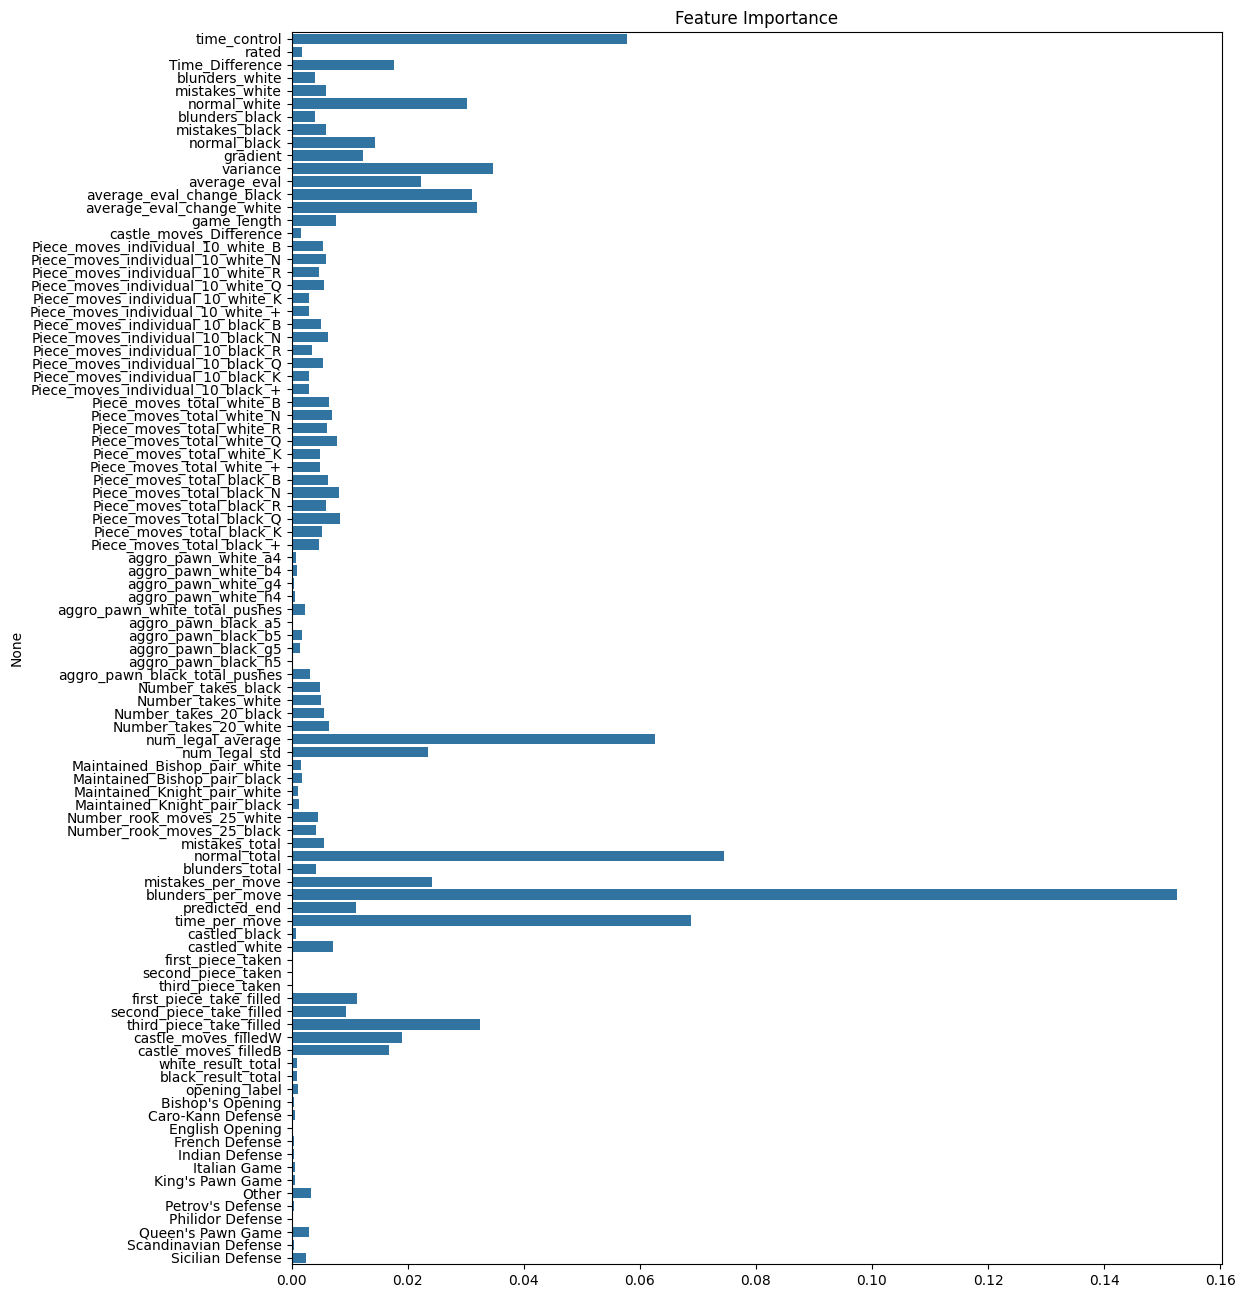

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

importances = forrest.feature_importances_
features = X.columns
plt.figure(figsize=(12, 16))
sns.barplot(x=importances, y=features)
plt.title("Feature Importance")
plt.show()

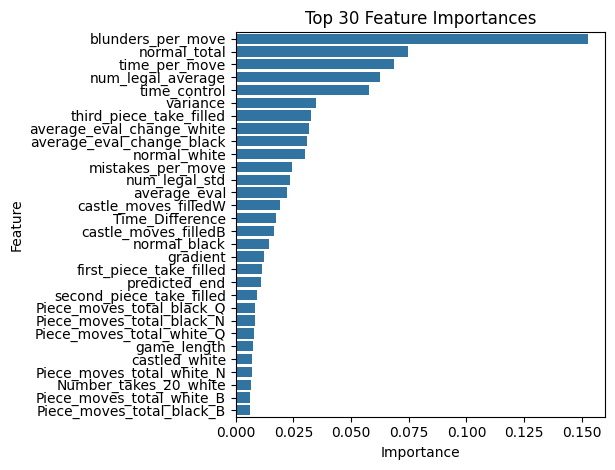

In [58]:
feat_imp_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

top_feats = feat_imp_df.sort_values(by='Importance', ascending=False).head(30) # Choose the top 30 features to re run again with just those to get more meaningfull patterns

sns.barplot(x='Importance', y='Feature', data=top_feats)
plt.title("Top 30 Feature Importances")
plt.tight_layout()
plt.show()

X_top30 = X[top_feats['Feature'].values]

In [59]:
X_train1_30, X_test_30, y_train1_30, y_test_30 = train_test_split(X_top30, y, test_size=0.2, random_state=42)

X_train_30, X_eval_30, y_train_30, y_eval_30 = train_test_split(X_train1, y_train1, test_size=0.2, random_state=42)


In [61]:
forrest = RandomForestRegressor(n_estimators=100, max_depth=25, min_samples_leaf=4, bootstrap=True, oob_score=True, random_state=42)
forrest.fit(X_train_30, y_train_30)
y_pred = forrest.predict(X_eval_30)

mse = mean_squared_error(y_eval_30, y_pred)
rmse = mean_squared_error(y_eval_30, y_pred)
mae = mean_absolute_error(y_eval_30, y_pred)
r2 = r2_score(y_eval_30, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

c:\Users\diman\Downloads\ML\lib\site-packages\sklearn\base.py:1363: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Mean Squared Error (MSE): 92803.1584
Root Mean Squared Error (RMSE): 92803.1584
Mean Absolute Error (MAE): 236.4190
R² Score: 0.4112


In [ ]:
mse = mean_squared_error(y_eval, y_pred)
rmse = mean_squared_error(y_eval, y_pred)
mae = mean_absolute_error(y_eval, y_pred)
r2 = r2_score(y_eval, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Squared Error (MSE): 92549.1543
Root Mean Squared Error (RMSE): 92549.1543
Mean Absolute Error (MAE): 235.9495
R² Score: 0.4128


In [ ]:
y_pred.shape

(4538,)

In [ ]:
model_XGB = XGBRegressor(n_estimators=200, learning_rate=0.03, max_depth=15, random_state=42,reg_lambda=0.5)
model_XGB.fit(X_train, y_train)
y_pred = model_XGB.predict(X_eval)

mse = mean_squared_error(y_eval, y_pred)
rmse = mean_squared_error(y_eval, y_pred)
mae = mean_absolute_error(y_eval, y_pred)
r2 = r2_score(y_eval, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Squared Error (MSE): 96469.7109
Root Mean Squared Error (RMSE): 96469.7109
Mean Absolute Error (MAE): 240.9792
R² Score: 0.3879


In [ ]:
from xgboost import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 20))  # Increase size to accommodate tree depth
plot_tree(model_XGB, num_trees=0, rankdir='LR')  # LR = left-to-right
plt.title("XGBoost Tree #0")
plt.show()

In [ ]:
X2 =pd.DataFrame(X)
X_with_const = sm.add_constant(X2)
X_with_const = pd.DataFrame(X_with_const)
y = pd.DataFrame(y)
# 2. Fit the model
model = sm.OLS(y, X_with_const).fit()

# 3. Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                Average   R-squared:                       0.411
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     227.2
Date:                Wed, 09 Jul 2025   Prob (F-statistic):               0.00
Time:                        11:03:49   Log-Likelihood:            -2.0264e+05
No. Observations:               28362   AIC:                         4.055e+05
Df Residuals:                   28274   BIC:                         4.062e+05
Df Model:                          87                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

In [ ]:
X_train

,time_control,rated,Time_Difference,blunders_white,mistakes_white,normal_white,blunders_black,mistakes_black,normal_black,gradient,variance,average_eval,average_eval_change_black,average_eval_change_white,game_length,castle_moves_Difference,Piece_moves_individual_10_white_B,Piece_moves_individual_10_white_N,Piece_moves_individual_10_white_R,Piece_moves_individual_10_white_Q,Piece_moves_individual_10_white_K,Piece_moves_individual_10_white_+,Piece_moves_individual_10_black_B,Piece_moves_individual_10_black_N,Piece_moves_individual_10_black_R,Piece_moves_individual_10_black_Q,Piece_moves_individual_10_black_K,Piece_moves_individual_10_black_+,Piece_moves_total_white_B,Piece_moves_total_white_N,Piece_moves_total_white_R,Piece_moves_total_white_Q,Piece_moves_total_white_K,Piece_moves_total_white_+,Piece_moves_total_black_B,Piece_moves_total_black_N,Piece_moves_total_black_R,Piece_moves_total_black_Q,Piece_moves_total_black_K,Piece_moves_total_black_+,aggro_pawn_white_a4,aggro_pawn_white_b4,aggro_pawn_white_g4,aggro_pawn_white_h4,aggro_pawn_white_total_pushes,aggro_pawn_black_a5,aggro_pawn_black_b5,aggro_pawn_black_g5,aggro_pawn_black_h5,aggro_pawn_black_total_pushes,Number_takes_black,Number_takes_white,Number_takes_20_black,Number_takes_20_white,num_legal_average,num_legal_std,Maintained_Bishop_pair_white,Maintained_Bishop_pair_black,Maintained_Knight_pair_white,Maintained_Knight_pair_black,Number_rook_moves_25_white,Number_rook_moves_25_black,mistakes_total,normal_total,blunders_total,mistakes_per_move,blunders_per_move,predicted_end,time_per_move,castled_black,castled_white,first_piece_taken,second_piece_taken,third_piece_taken,first_piece_take_filled,second_piece_take_filled,third_piece_take_filled,castle_moves_filledW,castle_moves_filledB,white_result_total,black_result_total,opening_label,Bishop's Opening,Caro-Kann Defense,English Opening,French Defense,Indian Defense,Italian Game,King's Pawn Game,Other,Petrov's Defense,Philidor Defense,Queen's Pawn Game,Scandinavian Defense,Sicilian Defense
16630,180,0,26.0,2,2,1,2,0,3,-0.010182,14.063082,-0.717273,-0.352727,1.035455,11,0,1,0,0,2,0,0,1,3,0,0,0,0,1,0,0,2,0,0,1,3,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,1,0,1,29.272727,11.841376,1,1,1,1,0,0,2,4,4,0.181818,0.363636,-0.112000,2.363636,0,0,0,0,0,22.0,22.0,22.0,22.0,22.0,1.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
1376,180,1,290.0,4,8,20,4,11,17,-0.083699,5.189863,-1.274154,0.281692,-0.389538,65,0,5,3,2,0,0,0,4,7,1,0,0,0,7,6,6,1,0,0,7,7,4,0,0,0,0,2,0,0,2,0,0,0,0,0,9,7,6,5,32.323077,5.468968,0,0,1,0,2,1,19,37,8,0.292308,0.123077,-5.440426,4.461538,1,1,1,1,1,17.0,18.0,19.0,5.0,7.0,1.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
16973,600,1,533.0,4,5,11,3,6,11,0.092902,9.026701,2.006098,0.014146,0.169024,41,0,6,3,0,3,0,2,1,8,1,1,1,0,6,3,0,4,0,3,1,8,1,1,1,0,0,0,0,0,0,0,0,0,0,0,4,4,4,4,32.902439,10.173015,0,1,0,0,0,1,11,22,7,0.268293,0.170732,3.809000,13.000000,1,1,1,1,1,8.0,16.0,16.0,6.0,8.0,1.0,0.0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
13918,600,1,1035.0,32,8,8,30,12,6,0.057107,43.790094,3.035155,-2.472577,2.553711,97,0,1,5,1,3,0,2,2,2,1,3,1,0,13,5,4,15,0,10,4,3,5,5,19,0,1,1,0,0,2,1,0,0,0,1,7,15,2,4,29.649485,17.770552,1,1,1,0,2,2,20,14,62,0.206186,0.639175,5.539375,10.670103,0,0,1,1,1,12.0,27.0,28.0,194.0,194.0,1.0,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
6660,180,1,362.0,4,8,26,5,11,23,0.011184,2.980220,-2.474872,0.272179,-0.245000,78,1,4,7,1,3,0,4,3,4,3,3,4,1,4,8,2,13,3,10,3,4,6,12,11,5,0,0,0,0,0,0,0,0,0,0,9,10,6,6,29.307692,14.373775,0,0,0,0,2,6,19,49,9,0.243590,0.115385,0.872323,4.641026,0,1,1,1,1,4.0,14.0,14.0,9.0,156.0,0.0,1.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28644,600,1,1214.0,7,14,29,9,11,30,0.045196,

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_eval_scaled = scaler.transform(X_eval)

In [ ]:
scaler_y = StandardScaler()
y_train = pd.DataFrame(y_train)
y_eval = pd.DataFrame(y_eval)

y_train_scaled = scaler_y.fit_transform(y_train)
y_eval_scaled  = scaler_y.transform(y_eval)

In [ ]:
X_train_scaled = pd.DataFrame(X_train_scaled)

In [ ]:
X_eval_scaled = pd.DataFrame(X_eval_scaled)

In [ ]:
from tensorflow.keras.initializers import GlorotUniform, GlorotNormal
from keras.regularizers import l2


In [ ]:
model = Sequential([
    Dense(95, kernel_initializer=GlorotUniform(), input_shape=(95,)),
    BatchNormalization(),
    Activation('relu'),

    Dropout(0.2),

    Dense(95, kernel_initializer=GlorotNormal(), kernel_regularizer=l2(0.05)),
    BatchNormalization(),
    Activation('relu'),

    Dropout(0.1),

    Dense(60, kernel_initializer=GlorotNormal(), kernel_regularizer=l2(0.05)),
    BatchNormalization(),
    Activation('relu'),

    Dropout(0.1),

    Dense(60, kernel_initializer=GlorotNormal(), kernel_regularizer=l2(0.05)),
    BatchNormalization(),
    Activation('relu'),

    Dropout(0.1),

    Dense(30, kernel_initializer=GlorotNormal(), kernel_regularizer=l2(0.05)),
    BatchNormalization(),
    Activation('relu'),

    Dropout(0.1),

    Dense(15, kernel_initializer=GlorotNormal(), kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Activation('relu'),

    Dropout(0.1),

    Dense(15, kernel_initializer=GlorotNormal(), kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Activation('relu'),

    Dropout(0.1),

    Dense(5, kernel_initializer=GlorotNormal(), kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Activation('relu'),

    Dense(5, kernel_initializer=GlorotNormal(), kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Activation('relu'),
    
    Dense(1)
])


c:\Users\diman\Downloads\ML\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.5,
    patience = 7,
    min_lr = 1e-6,
    verbose=1
)

In [ ]:
#optimizer = Adam(learning_rate=0.01)
#optimizer = SGD(learning_rate=0.2, momentum=0.9)

model.compile(optimizer='adam', loss='mae')


In [ ]:
base_log_dir = r"C:\Users\diman\Downloads\Chess_Elo_Guesser"
run_id = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = os.path.join(base_log_dir, "logs", run_id)

tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
model.fit(X_train_scaled, y_train_scaled, validation_data=(X_eval_scaled, y_eval_scaled), epochs=100, callbacks=[reduce_lr, early_stop])


Epoch 1/100
568/568 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 10.5757 - val_loss: 3.0626 - learning_rate: 0.0010
Epoch 2/100
568/568 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2.3688 - val_loss: 1.1649 - learning_rate: 0.0010
Epoch 3/100
568/568 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.0660 - val_loss: 0.8725 - learning_rate: 0.0010
Epoch 4/100
568/568 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8470 - val_loss: 0.7832 - learning_rate: 0.0010
Epoch 5/100
568/568 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7660 - val_loss: 0.7855 - learning_rate: 0.0010
Epoch 6/100
568/568 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7362 - val_loss: 0.7628 - learning_rate: 0.0010
Epoch 7/100
568/568 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7226 - val_loss: 0.6820 - learning_rate: 0.0010
Epoch 8/100
568/568 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7047 - val_loss: 0.8172 - learning_rate: 0.0010
Epoch 9/100
568/568 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6817 - val_loss: 0.6664 - learning_rate: 0.0010


In [ ]:
y_train_scaled

array([[-1.46916821],
       [-1.01325498],
       [-0.05521265],
       ...,
       [-1.45667744],
       [-0.96828819],
       [ 0.9515437 ]])

In [ ]:
y_pred = model.predict(X_eval_scaled)

mse = mean_squared_error(y_eval_scaled, y_pred)
rmse = mean_squared_error(y_eval_scaled, y_pred)
mae = mean_absolute_error(y_eval_scaled, y_pred)
r2 = r2_score(y_eval_scaled, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Mean Squared Error (MSE): 0.5353
Root Mean Squared Error (RMSE): 0.5353
Mean Absolute Error (MAE): 0.5542
R² Score: 0.4557


In [ ]:
y_pred

array([[-0.00311142],
       [ 1.1882563 ],
       [ 1.2216849 ],
       ...,
       [ 0.85608166],
       [-0.55311966],
       [-0.00852132]], dtype=float32)

In [ ]:
y_pred_unscaled = scaler_y.inverse_transform(y_pred)
y_eval_unscaled = scaler_y.inverse_transform(y_eval_scaled)
mse_unscaled = mean_squared_error(y_eval_unscaled, y_pred_unscaled)
mae = mean_absolute_error(y_eval_unscaled, y_pred_unscaled)


In [ ]:
print(mse_unscaled)
print(mae)

85782.51875227831
221.83494618307813


In [ ]:
from tensorflow.keras.layers import Add, Input


def residual_block(x, units, dropout_rate=0.1, l2_reg=0.01):
    """Residual block with same input/output shape"""
    shortcut = x  # Save for addition later

    x = Dense(units, kernel_initializer=GlorotNormal(), kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropout_rate)(x)

    # If dimensions mismatch, project shortcut
    if shortcut.shape[-1] != units:
        shortcut = Dense(units, kernel_initializer=GlorotNormal(), kernel_regularizer=l2(l2_reg))(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

In [ ]:
from tensorflow.keras.models import Model


In [ ]:
def build_model(input_shape=(95,)):
    inputs = Input(shape=input_shape)
    
    # Initial dense layer
    x = Dense(95, kernel_initializer=GlorotNormal(), kernel_regularizer=l2(0.05))(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)

    # Mixed architecture
    x = residual_block(x, 95, dropout_rate=0.1, l2_reg=0.05)

    x = Dense(60, kernel_initializer=GlorotNormal(), kernel_regularizer=l2(0.05))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.1)(x)

    x = residual_block(x, 60, dropout_rate=0.1, l2_reg=0.05)

    x = Dense(30, kernel_initializer=GlorotNormal(), kernel_regularizer=l2(0.05))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.1)(x)

    x = residual_block(x, 15, dropout_rate=0.1, l2_reg=0.01)
    x = residual_block(x, 15, dropout_rate=0.1, l2_reg=0.01)

    x = Dense(5, kernel_initializer=GlorotNormal(), kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Dense(5, kernel_initializer=GlorotNormal(), kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    outputs = Dense(1)(x)

    model = Model(inputs, outputs)
    return model

In [ ]:
model = build_model()
model.compile(optimizer='adam', loss='huber')
#model.summary()

In [ ]:
model.fit(X_train_scaled, y_train_scaled, validation_data=(X_eval_scaled, y_eval_scaled), epochs=200, callbacks=[reduce_lr, early_stop])

Epoch 1/200
568/568 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 9.4215 - val_loss: 0.6672 - learning_rate: 0.0010
Epoch 2/200
568/568 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5110 - val_loss: 0.3717 - learning_rate: 0.0010
Epoch 3/200
568/568 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3783 - val_loss: 0.3725 - learning_rate: 0.0010
Epoch 4/200
568/568 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3632 - val_loss: 0.3630 - learning_rate: 0.0010
Epoch 5/200
568/568 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3693 - val_loss: 0.3589 - learning_rate: 0.0010
Epoch 6/200
568/568 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3698 - val_loss: 0.3627 - learning_rate: 0.0010
Epoch 7/200
568/568 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3710 - val_loss: 0.3605 - learning_rate: 0.0010
Epoch 8/200
568/568 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3619 - val_loss: 0.3569 - learning_rate: 0.0010
Epoch 9/200
568/568 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3673 - val_loss: 0.3822 - learning_rate: 0.0010
E

In [ ]:
y_pred = model.predict(X_eval_scaled)

mse = mean_squared_error(y_eval_scaled, y_pred)
rmse = mean_squared_error(y_eval_scaled, y_pred)
mae = mean_absolute_error(y_eval_scaled, y_pred)
r2 = r2_score(y_eval_scaled, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")
y_pred
y_pred_unscaled = scaler_y.inverse_transform(y_pred)
y_eval_unscaled = scaler_y.inverse_transform(y_eval_scaled)
mse_unscaled = mean_squared_error(y_eval_unscaled, y_pred_unscaled)
mae = mean_absolute_error(y_eval_unscaled, y_pred_unscaled)

print(mse_unscaled)
print(mae)

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Mean Squared Error (MSE): 0.5382
Root Mean Squared Error (RMSE): 0.5382
Mean Absolute Error (MAE): 0.5656
R² Score: 0.4528
86243.13575318307
226.40311852527012


In [ ]:
def predict_with_mc_dropout(model, x, T=100):
    preds = []
    for _ in tf.range(T):
        preds.append(model(x, training=True))  # training=True activates dropout
    return tf.stack(preds)  # shape: [T, batch_size, output_dim]

In [ ]:
preds = predict_with_mc_dropout(model, X_eval_scaled, T=100)
mean_pred = tf.reduce_mean(preds, axis=0)
std_pred = tf.math.reduce_std(preds, axis=0)

In [ ]:
std_pred_unscaled = std_pred * scaler_y.scale_


In [ ]:
std_pred_unscaled

<tf.Tensor: shape=(4538, 1), dtype=float32, numpy=
array([[62.075397],
       [80.33218 ],
       [84.80128 ],
       ...,
       [70.66943 ],
       [67.78267 ],
       [69.11017 ]], dtype=float32)>

In [ ]:
print(tf.reduce_mean(std_pred_unscaled))

tf.Tensor(63.64787, shape=(), dtype=float32)


In [ ]:
pred_w_deviations_low = mean_pred-5*std_pred
pred_w_deviations_high = mean_pred+5*std_pred

In [ ]:
pred_w_deviations_low = mean_pred - 5 * std_pred
pred_w_deviations_high = mean_pred + 5 * std_pred

# Check if true value is inside confidence interval
within_interval = ((y_eval_scaled >= pred_w_deviations_low) & 
                   (y_eval_scaled <= pred_w_deviations_high))

In [ ]:
within_interval = pd.DataFrame(within_interval)
print(within_interval.astype(int))


      0
0     1
1     1
2     1
3     1
4     1
...  ..
4533  1
4534  1
4535  1
4536  1
4537  0

[4538 rows x 1 columns]


In [ ]:
percent_inside = np.mean(within_interval)
print(percent_inside)

0.7276333186425739


In [ ]:
residuals = y_eval_unscaled - y_pred_unscaled
std_dev = np.std(residuals, ddof=1)
print("Standard Deviation of Residuals:", std_dev)


Standard Deviation of Residuals: 292.5745574026795


In [ ]:
origin = pd.DataFrame(X_eval["Difference"])

KeyError: 'Difference'

In [ ]:
y_eval_unscaled

array([[ -18.],
       [  40.],
       [  27.],
       ...,
       [-139.],
       [-128.],
       [  -3.]])

In [ ]:
y_pred2 = y_pred_unscaled + origin
plt.scatter(y_eval_unscaled,y_pred_unscaled - y_eval_unscaled)

NameError: name 'origin' is not defined

In [ ]:
print("Var(y_eval_scaled):", np.var(y_eval))
print("Std(y_eval_scaled):", np.std(y_eval))

# Are the arrays in the same unit?
print(y_eval[:5].ravel())   # should be roughly –2 … +2 for StandardScaler
print(y_pred[:5].ravel())

Var(y_eval_scaled): Difference    10927.310427
dtype: float64
Std(y_eval_scaled): Difference    104.533776
dtype: float64


c:\Users\diman\Downloads\ML\lib\site-packages\numpy\_core\fromnumeric.py:4316: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
c:\Users\diman\Downloads\ML\lib\site-packages\numpy\_core\fromnumeric.py:4109: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


AttributeError: 'DataFrame' object has no attribute 'ravel'

In [ ]:
y_eval_orig = scaler_y.inverse_transform(y_eval_scaled)
y_pred_orig = scaler_y.inverse_transform(y_pred)

mse  = mean_squared_error(y_eval_orig, y_pred_orig)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_eval_orig, y_pred_orig)
r2   = r2_score(y_eval_orig, y_pred_orig)